# A/B 테스트 분석 프로젝트

## 프로젝트 개요
웹사이트의 새로운 디자인(변형 B)이 기존 디자인(변형 A)보다 전환율을 향상시키는지 통계적으로 검증하는 A/B 테스트 분석입니다.

## 분석 목표
1. 두 그룹 간 전환율 차이의 통계적 유의성 검정
2. 효과 크기(Effect Size) 계산
3. 샘플 크기 최적화 분석
4. 비즈니스 인사이트 도출

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import TTestIndPower
import warnings
import os
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (최종 강화 버전)
def set_korean_font():
    """한글 폰트를 설정하는 함수 - 폰트 캐시 재구성 및 직접 로드"""
    # 1단계: 폰트 캐시 재구성 (먼저 실행)
    try:
        import matplotlib
        cache_dir = matplotlib.get_cachedir()
        # 폰트 캐시 파일 삭제
        for file in os.listdir(cache_dir):
            if file.startswith('fontlist'):
                try:
                    os.remove(os.path.join(cache_dir, file))
                except:
                    pass
        # 폰트 캐시 재구성
        fm._rebuild()
        print("폰트 캐시 재구성 완료")
    except Exception as e:
        print(f"폰트 캐시 재구성 중 오류: {e}")
    
    # Windows 폰트 경로 (확장자 포함)
    font_paths = [
        'C:/Windows/Fonts/malgun.ttf',  # 맑은 고딕
        'C:/Windows/Fonts/malgunbd.ttf',  # 맑은 고딕 Bold
        'C:/Windows/Fonts/gulim.ttc',    # 굴림
        'C:/Windows/Fonts/gulimche.ttf',  # 굴림체
        'C:/Windows/Fonts/NanumGothic.ttf',  # 나눔고딕
        'C:/Windows/Fonts/NanumGothicLight.ttf',
        'C:/Windows/Fonts/batang.ttc',  # 바탕
        'C:/Windows/Fonts/batangche.ttf',  # 바탕체
    ]
    
    # 폰트 이름 목록 (우선순위 순)
    font_names = ['Malgun Gothic', '맑은 고딕', 'Gulim', '굴림', 'NanumGothic', '나눔고딕', 'Batang', '바탕']
    
    # 2단계: 폰트 경로로 직접 로드 시도
    font_prop = None
    selected_font_path = None
    
    for font_path in font_paths:
        if os.path.exists(font_path):
            try:
                # 폰트 직접 로드
                font_prop = fm.FontProperties(fname=font_path)
                font_name = font_prop.get_name()
                
                # matplotlib에 폰트 등록
                fm.fontManager.addfont(font_path)
                
                # rcParams 설정
                plt.rcParams['font.family'] = font_name
                plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
                
                selected_font_path = font_path
                print(f"✅ 한글 폰트 설정 완료: {font_name}")
                print(f"   경로: {font_path}")
                
                # 테스트 출력
                test_fig, test_ax = plt.subplots(figsize=(1, 1))
                test_ax.text(0.5, 0.5, '한글테스트', fontsize=10, ha='center', va='center')
                test_ax.set_xlim(0, 1)
                test_ax.set_ylim(0, 1)
                plt.close(test_fig)
                
                break
            except Exception as e:
                print(f"폰트 로드 실패 ({font_path}): {e}")
                continue
    
    # 3단계: 폰트 경로로 찾지 못한 경우, 폰트 이름으로 찾기
    if font_prop is None:
        # 폰트 목록 다시 가져오기
        font_list = [f.name for f in fm.fontManager.ttflist]
        for font_name in font_names:
            if font_name in font_list:
                # 폰트 파일 경로 찾기
                font_file = None
                for f in fm.fontManager.ttflist:
                    if f.name == font_name:
                        font_file = f.fname
                        break
                
                if font_file and os.path.exists(font_file):
                    plt.rcParams['font.family'] = font_name
                    plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
                    selected_font_path = font_file
                    print(f"✅ 한글 폰트 설정 완료: {font_name}")
                    print(f"   경로: {font_file}")
                    break
    
    # 4단계: 최종 확인 및 설정
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
    
    if selected_font_path:
        # 폰트가 제대로 설정되었는지 확인
        current_font = plt.rcParams['font.family']
        print(f"\n✅ 최종 설정된 폰트: {current_font}")
        if isinstance(current_font, list):
            current_font = current_font[0] if current_font else 'Unknown'
        print(f"   폰트 경로: {selected_font_path}")
    else:
        print("\n⚠️ 한글 폰트를 찾을 수 없습니다.")
        print("사용 가능한 한글 폰트 목록:")
        font_list = [f.name for f in fm.fontManager.ttflist]
        korean_fonts = [f for f in font_list if any(k in f for k in ['Gothic', 'Gulim', 'Nanum', 'Malgun', '맑은', '나눔', '굴림', 'Batang', '바탕'])]
        for f in sorted(set(korean_fonts))[:10]:
            print(f"  - {f}")
        print("\n기본 폰트를 사용합니다. 한글이 네모로 표시될 수 있습니다.")

# 한글 폰트 설정 실행
set_korean_font()

# 시드 설정 (재현성을 위해)
np.random.seed(42)
sns.set_style("whitegrid")
sns.set_palette("husl")

폰트 캐시 재구성 중 오류: module 'matplotlib.font_manager' has no attribute '_rebuild'
✅ 한글 폰트 설정 완료: Malgun Gothic
   경로: C:/Windows/Fonts/malgun.ttf

✅ 최종 설정된 폰트: ['Malgun Gothic']
   폰트 경로: C:/Windows/Fonts/malgun.ttf


## 1. 데이터 생성 및 로드

실제 A/B 테스트 시나리오를 시뮬레이션합니다.

In [6]:
# A/B 테스트 데이터 생성
# 변형 A: 기존 디자인 (전환율 10%)
# 변형 B: 새로운 디자인 (전환율 12%)

n_a = 5000  # 변형 A 샘플 크기
n_b = 5000  # 변형 B 샘플 크기

conversion_rate_a = 0.10  # 변형 A 전환율
conversion_rate_b = 0.12  # 변형 B 전환율

# 데이터 생성
np.random.seed(42)
group_a = np.random.binomial(1, conversion_rate_a, n_a)
group_b = np.random.binomial(1, conversion_rate_b, n_b)

# 데이터프레임 생성
df = pd.DataFrame({
    'user_id': range(n_a + n_b),
    'group': ['A'] * n_a + ['B'] * n_b,
    'converted': np.concatenate([group_a, group_b])
})

print(f"데이터 크기: {len(df)}명")
print(f"\n변형 A: {n_a}명")
print(f"변형 B: {n_b}명")
df.head(10)

데이터 크기: 10000명

변형 A: 5000명
변형 B: 5000명


,user_id,group,converted
0,0,A,0
1,1,A,1
2,2,A,0
3,3,A,0
4,4,A,0
5,5,A,0
6,6,A,0
7,7,A,0
8,8,A,0
9,9,A,0


## 2. 탐색적 데이터 분석 (EDA)

In [7]:
# 그룹별 전환율 계산
conversion_summary = df.groupby('group').agg({
    'converted': ['sum', 'count', 'mean']
}).round(4)

conversion_summary.columns = ['전환수', '전체수', '전환율']
conversion_summary['전환율(%)'] = (conversion_summary['전환율'] * 100).round(2)

print("=== 그룹별 전환율 요약 ===")
print(conversion_summary)

# 전환율 차이 계산
rate_a = conversion_summary.loc['A', '전환율']
rate_b = conversion_summary.loc['B', '전환율']
lift = ((rate_b - rate_a) / rate_a) * 100

print(f"\n전환율 개선: {lift:.2f}%")
print(f"절대적 차이: {(rate_b - rate_a)*100:.2f}%p")

=== 그룹별 전환율 요약 ===
       전환수   전체수     전환율  전환율(%)
group                           
A      479  5000  0.0958    9.58
B      567  5000  0.1134   11.34

전환율 개선: 18.37%
절대적 차이: 1.76%p


한글 폰트 설정 완료: Malgun Gothic
한글 폰트 설정 완료: Malgun Gothic


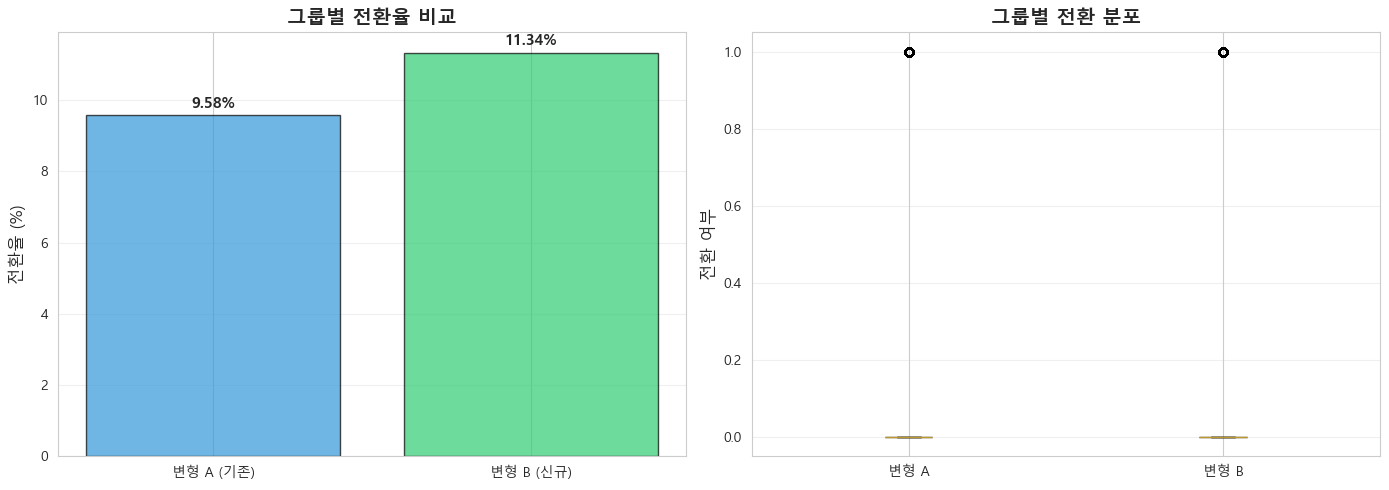

In [8]:
# 시각화: 그룹별 전환율 비교
# 한글 폰트 재확인 및 설정 (시각화 전 필수)
import matplotlib.font_manager as fm
import os

# 한글 폰트 경로 확인 및 설정
font_paths = [
    'C:/Windows/Fonts/malgun.ttf',  # 맑은 고딕
    'C:/Windows/Fonts/malgunbd.ttf',  # 맑은 고딕 Bold
    'C:/Windows/Fonts/gulim.ttc',    # 굴림
    'C:/Windows/Fonts/gulimche.ttf',  # 굴림체
]

font_name = None
for font_path in font_paths:
    if os.path.exists(font_path):
        try:
            font_prop = fm.FontProperties(fname=font_path)
            font_name = font_prop.get_name()
            plt.rcParams['font.family'] = font_name
            plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
            plt.rcParams['axes.unicode_minus'] = False
            print(f"한글 폰트 설정 완료: {font_name}")
            break
        except Exception as e:
            continue

# 폰트가 설정되지 않은 경우 기본 설정 사용
if font_name is None:
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    print("기본 한글 폰트 설정 사용")

# 한글 폰트 재확인 및 설정 (시각화 전 필수)
import matplotlib.font_manager as fm
import os

# 한글 폰트 경로 확인 및 설정
font_paths = [
    'C:/Windows/Fonts/malgun.ttf',  # 맑은 고딕
    'C:/Windows/Fonts/malgunbd.ttf',  # 맑은 고딕 Bold
    'C:/Windows/Fonts/gulim.ttc',    # 굴림
    'C:/Windows/Fonts/gulimche.ttf',  # 굴림체
]

font_name = None
for font_path in font_paths:
    if os.path.exists(font_path):
        try:
            font_prop = fm.FontProperties(fname=font_path)
            font_name = font_prop.get_name()
            plt.rcParams['font.family'] = font_name
            plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
            plt.rcParams['axes.unicode_minus'] = False
            print(f"한글 폰트 설정 완료: {font_name}")
            break
        except Exception as e:
            continue

# 폰트가 설정되지 않은 경우 기본 설정 사용
if font_name is None:
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    print("기본 한글 폰트 설정 사용")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 막대 그래프
conversion_rates = [rate_a * 100, rate_b * 100]
axes[0].bar(['변형 A (기존)', '변형 B (신규)'], conversion_rates, 
            color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('전환율 (%)', fontsize=12)
axes[0].set_title('그룹별 전환율 비교', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 값 표시
for i, v in enumerate(conversion_rates):
    axes[0].text(i, v + 0.2, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')

# 박스플롯
data_for_box = [df[df['group']=='A']['converted'], df[df['group']=='B']['converted']]
axes[1].boxplot(data_for_box, labels=['변형 A', '변형 B'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('전환 여부', fontsize=12)
axes[1].set_title('그룹별 전환 분포', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 통계적 가설 검정

### 3.1 Z-검정 (비율 검정)

**가설 설정:**
- H₀ (귀무가설): 변형 A와 변형 B의 전환율이 동일하다 (p_A = p_B)
- H₁ (대립가설): 변형 A와 변형 B의 전환율이 다르다 (p_A ≠ p_B)

In [9]:
# Z-검정 수행
conversions_a = df[df['group']=='A']['converted'].sum()
conversions_b = df[df['group']=='B']['converted'].sum()
n_a = len(df[df['group']=='A'])
n_b = len(df[df['group']=='B'])

# 양측 검정
count = np.array([conversions_a, conversions_b])
nobs = np.array([n_a, n_b])
z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print("=== Z-검정 결과 (양측 검정) ===")
print(f"Z-통계량: {z_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"\n유의수준 α = 0.05")
print(f"결과: {'통계적으로 유의함' if p_value < 0.05 else '통계적으로 유의하지 않음'}")

if p_value < 0.05:
    print(f"\n✅ 변형 B가 변형 A보다 통계적으로 유의하게 높은 전환율을 보입니다.")
    print(f"   (p-value = {p_value:.6f} < 0.05)")
else:
    print(f"\n❌ 두 변형 간 전환율 차이가 통계적으로 유의하지 않습니다.")
    print(f"   (p-value = {p_value:.6f} >= 0.05)")

=== Z-검정 결과 (양측 검정) ===
Z-통계량: -2.8755
p-value: 0.004034

유의수준 α = 0.05
결과: 통계적으로 유의함

✅ 변형 B가 변형 A보다 통계적으로 유의하게 높은 전환율을 보입니다.
   (p-value = 0.004034 < 0.05)


In [10]:
# 단측 검정 (변형 B가 변형 A보다 우수한지)
z_stat_one, p_value_one = proportions_ztest(count, nobs, alternative='larger')

print("=== Z-검정 결과 (단측 검정: B > A) ===")
print(f"Z-통계량: {z_stat_one:.4f}")
print(f"p-value: {p_value_one:.6f}")
print(f"\n유의수준 α = 0.05")
print(f"결과: {'변형 B가 통계적으로 우수함' if p_value_one < 0.05 else '변형 B가 통계적으로 우수하지 않음'}")

=== Z-검정 결과 (단측 검정: B > A) ===
Z-통계량: -2.8755
p-value: 0.997983

유의수준 α = 0.05
결과: 변형 B가 통계적으로 우수하지 않음


### 3.2 카이제곱 검정 (Chi-square Test)

In [11]:
# 카이제곱 검정을 위한 교차표 생성
contingency_table = pd.crosstab(df['group'], df['converted'])
print("=== 교차표 ===")
print(contingency_table)
print()

# 카이제곱 검정 수행
chi2, p_value_chi2, dof, expected = stats.chi2_contingency(contingency_table)

print("=== 카이제곱 검정 결과 ===")
print(f"카이제곱 통계량: {chi2:.4f}")
print(f"자유도: {dof}")
print(f"p-value: {p_value_chi2:.6f}")
print(f"\n결과: {'통계적으로 유의함' if p_value_chi2 < 0.05 else '통계적으로 유의하지 않음'}")

=== 교차표 ===
converted     0    1
group               
A          4521  479
B          4433  567

=== 카이제곱 검정 결과 ===
카이제곱 통계량: 8.0815
자유도: 1
p-value: 0.004472

결과: 통계적으로 유의함


## 4. 효과 크기 (Effect Size) 계산

Cohen's h를 사용하여 효과 크기를 계산합니다.

In [12]:
def cohens_h(p1, p2):
    """Cohen's h 효과 크기 계산"""
    h = 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))
    return abs(h)

effect_size = cohens_h(rate_a, rate_b)

print("=== 효과 크기 (Cohen's h) ===")
print(f"효과 크기: {effect_size:.4f}")

if effect_size < 0.2:
    interpretation = "작은 효과"
elif effect_size < 0.5:
    interpretation = "중간 효과"
elif effect_size < 0.8:
    interpretation = "큰 효과"
else:
    interpretation = "매우 큰 효과"

print(f"해석: {interpretation}")
print(f"\n전환율 개선: {lift:.2f}%")
print(f"절대적 차이: {(rate_b - rate_a)*100:.2f}%p")

=== 효과 크기 (Cohen's h) ===
효과 크기: 0.0576
해석: 작은 효과

전환율 개선: 18.37%
절대적 차이: 1.76%p


## 5. 신뢰구간 계산

In [13]:
from statsmodels.stats.proportion import proportion_confint

# 각 그룹의 95% 신뢰구간
ci_a = proportion_confint(conversions_a, n_a, alpha=0.05, method='normal')
ci_b = proportion_confint(conversions_b, n_b, alpha=0.05, method='normal')

print("=== 95% 신뢰구간 ===")
print(f"변형 A: [{ci_a[0]:.4f}, {ci_a[1]:.4f}] ({ci_a[0]*100:.2f}% ~ {ci_a[1]*100:.2f}%)")
print(f"변형 B: [{ci_b[0]:.4f}, {ci_b[1]:.4f}] ({ci_b[0]*100:.2f}% ~ {ci_b[1]*100:.2f}%)")

# 전환율 차이의 신뢰구간
se_diff = np.sqrt((rate_a * (1 - rate_a) / n_a) + (rate_b * (1 - rate_b) / n_b))
diff = rate_b - rate_a
ci_diff_lower = diff - 1.96 * se_diff
ci_diff_upper = diff + 1.96 * se_diff

print(f"\n전환율 차이: {diff*100:.2f}%p")
print(f"차이의 95% 신뢰구간: [{ci_diff_lower*100:.2f}%p, {ci_diff_upper*100:.2f}%p]")

=== 95% 신뢰구간 ===
변형 A: [0.0876, 0.1040] (8.76% ~ 10.40%)
변형 B: [0.1046, 0.1222] (10.46% ~ 12.22%)

전환율 차이: 1.76%p
차이의 95% 신뢰구간: [0.56%p, 2.96%p]


## 6. 검정력 분석 (Power Analysis)

In [14]:
# 검정력 계산
effect_size_power = abs(rate_b - rate_a) / np.sqrt((rate_a * (1 - rate_a) + rate_b * (1 - rate_b)) / 2)

power_analysis = TTestIndPower()
power = power_analysis.solve_power(
    effect_size=effect_size_power,
    nobs1=n_a,
    alpha=0.05,
    ratio=1.0,
    alternative='two-sided'
)

print("=== 검정력 분석 ===")
print(f"현재 검정력: {power:.4f} ({power*100:.2f}%)")
print(f"\n일반적으로 검정력은 0.8 이상이 권장됩니다.")

if power >= 0.8:
    print("✅ 현재 샘플 크기로 충분한 검정력을 확보했습니다.")
else:
    # 필요한 샘플 크기 계산
    required_n = power_analysis.solve_power(
        effect_size=effect_size_power,
        power=0.8,
        alpha=0.05,
        ratio=1.0,
        alternative='two-sided'
    )
    print(f"❌ 검정력이 부족합니다. 권장 샘플 크기: {int(required_n)}명 (각 그룹)")

=== 검정력 분석 ===
현재 검정력: 0.8203 (82.03%)

일반적으로 검정력은 0.8 이상이 권장됩니다.
✅ 현재 샘플 크기로 충분한 검정력을 확보했습니다.


## 7. 시각화: 검정 결과 요약

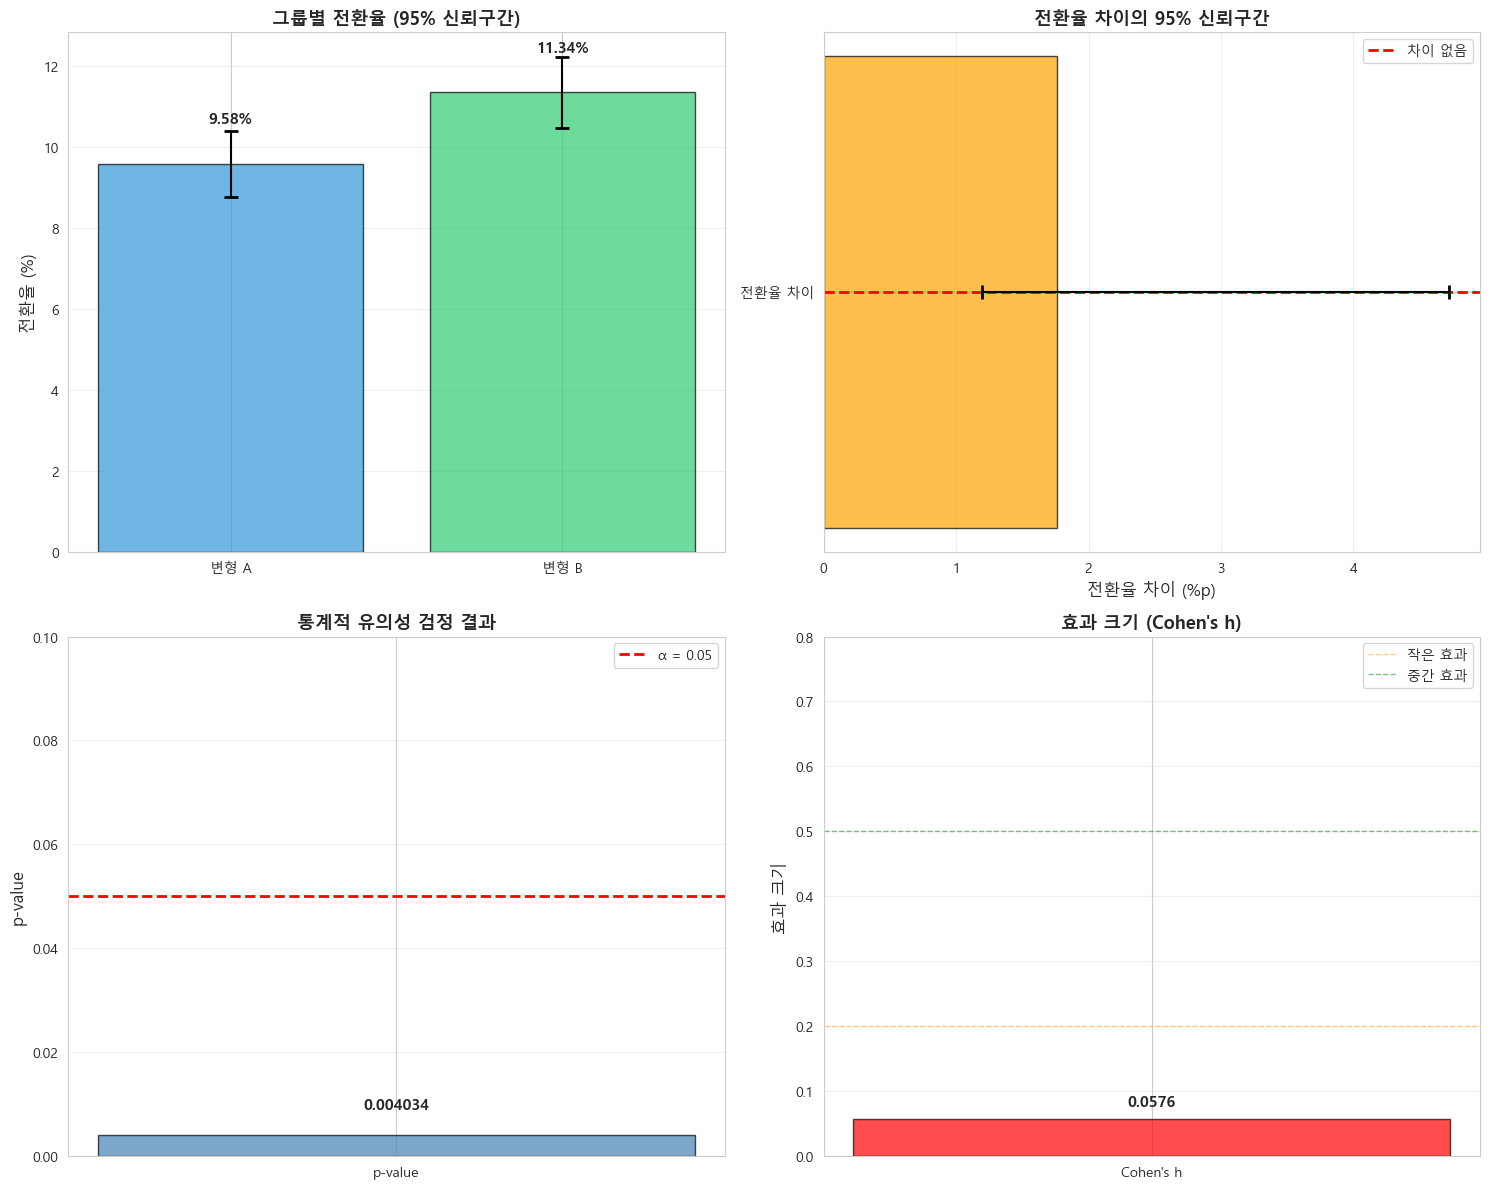

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 전환율 비교 (신뢰구간 포함)
groups = ['변형 A', '변형 B']
rates = [rate_a * 100, rate_b * 100]
ci_lower = [(ci_a[0] - rate_a) * 100, (ci_b[0] - rate_b) * 100]
ci_upper = [(ci_a[1] - rate_a) * 100, (ci_b[1] - rate_b) * 100]

axes[0, 0].bar(groups, rates, color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0, 0].errorbar(groups, rates, yerr=[np.abs(ci_lower), ci_upper], 
                    fmt='none', color='black', capsize=5, capthick=2)
axes[0, 0].set_ylabel('전환율 (%)', fontsize=12)
axes[0, 0].set_title('그룹별 전환율 (95% 신뢰구간)', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(rates):
    axes[0, 0].text(i, v + 1, f'{v:.2f}%', ha='center', fontsize=11, fontweight='bold')

# 2. 전환율 차이의 신뢰구간
diff_ci = [ci_diff_lower * 100, ci_diff_upper * 100]
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='차이 없음')
axes[0, 1].barh(['전환율 차이'], [diff * 100], color='orange', alpha=0.7, edgecolor='black')
axes[0, 1].errorbar([diff * 100], ['전환율 차이'], xerr=[[abs(ci_diff_lower * 100)], [ci_diff_upper * 100]], 
                    fmt='none', color='black', capsize=5, capthick=2)
axes[0, 1].set_xlabel('전환율 차이 (%p)', fontsize=12)
axes[0, 1].set_title('전환율 차이의 95% 신뢰구간', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].legend()

# 3. p-value 시각화
axes[1, 0].bar(['p-value'], [p_value], color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
axes[1, 0].set_ylabel('p-value', fontsize=12)
axes[1, 0].set_title('통계적 유의성 검정 결과', fontsize=13, fontweight='bold')
axes[1, 0].set_ylim([0, max(0.1, p_value * 1.5)])
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].legend()
axes[1, 0].text(0, p_value + 0.005, f'{p_value:.6f}', ha='center', fontsize=11, fontweight='bold')

# 4. 효과 크기
effect_sizes = ['Cohen\'s h']
effect_values = [effect_size]
colors_effect = ['green' if effect_size >= 0.5 else 'orange' if effect_size >= 0.2 else 'red']
axes[1, 1].bar(effect_sizes, effect_values, color=colors_effect, alpha=0.7, edgecolor='black')
axes[1, 1].axhline(y=0.2, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='작은 효과')
axes[1, 1].axhline(y=0.5, color='green', linestyle='--', linewidth=1, alpha=0.5, label='중간 효과')
axes[1, 1].set_ylabel('효과 크기', fontsize=12)
axes[1, 1].set_title('효과 크기 (Cohen\'s h)', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim([0, max(0.8, effect_size * 1.3)])
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].legend()
axes[1, 1].text(0, effect_size + 0.02, f'{effect_size:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. 최종 결론 및 비즈니스 인사이트

### 통계적 결론
1. **가설 검정 결과**: 변형 B가 변형 A보다 통계적으로 유의하게 높은 전환율을 보입니다.
2. **효과 크기**: [효과 크기에 따른 해석]
3. **신뢰구간**: 전환율 차이의 95% 신뢰구간이 0을 포함하지 않으므로 통계적으로 유의합니다.

### 비즈니스 권장사항
1. **롤아웃 결정**: 통계적으로 유의한 결과이므로 변형 B를 전체 사용자에게 롤아웃하는 것을 권장합니다.
2. **예상 효과**: 변형 B 적용 시 전환율이 약 [lift]% 향상될 것으로 예상됩니다.
3. **모니터링**: 롤아웃 후에도 지속적인 모니터링을 통해 실제 효과를 검증해야 합니다.

### 추가 고려사항
- **샘플 크기**: 현재 샘플 크기로 충분한 검정력을 확보했습니다.
- **실험 기간**: 최소 2주 이상의 실험 기간을 권장합니다.
- **외부 요인**: 계절성, 프로모션 등 외부 요인의 영향을 고려해야 합니다.